<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Object_Detection/RetinaNet(2017).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference
- https://github.com/kuangliu/pytorch-retinanet

In [1]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 37.6MB 135kB/s 
     |████████████████████████████████| 952kB 76.8MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Dataset 불러오기

In [3]:
path2data = '/content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [4]:

# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [5]:
# PyTorch에서 제공하는 VOC dataset class를 수정하여 사용합니다.
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일 분석하여 dict으로 받아오기

        targets = []
        labels = []
        # class와 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            label[0] = label[0]
            label[2] = label[2]
            label[1] = label[1]
            label[3] = label[3]

            targets.append(list(label[:4]))
            labels.append(label[4])

        if self.transforms:

            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml 파일을 dictionary로 반환
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [6]:
# train, validation dataset 생성.
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)


Extracting /content/voc/VOCtrainval_06-Nov-2007.tar to /content/voc



Extracting /content/voc/VOCtest_06-Nov-2007.tar to /content/voc


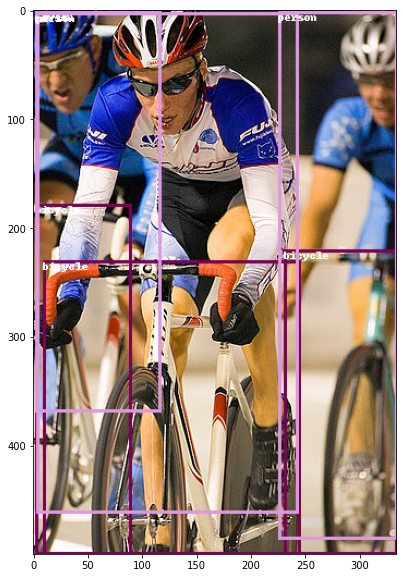

In [7]:
# 샘플 이미지 확인
img, target, label = train_ds[2] # img: np.array, target: x1, y1, x2, y2, class
colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 컬러
def show(img, targets, labels, classes=classes): # 시각화 함수
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg,label in zip(targets,labels):
        id_ = int(label) # class
        bbox = tg[:4]    # [x1, y1, x2, y2]
        bbox[0] = bbox[0]
        bbox[2] = bbox[2]
        bbox[1] = bbox[1]
        bbox[3] = bbox[3]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))
plt.figure(figsize=(10,10))
show(img, target, label)

# Transformation 정의

In [8]:
IMAGE_SIZE = 600
scale = 1.0

train_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensor()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

val_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensor()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

train_ds.transforms = train_transforms
val_ds.transforms = val_transforms

In [9]:
# targets를 RetinaNet 결과값과 동일한 형태로 변경합니다. 손실 함수를 계산하기 위함입니다.
class DataEncoder:
    def __init__(self):
        self.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512*512.] # 피쳐맵 크기 p3 -> p7
        self.aspect_ratios = [1/2., 1/1., 2/1.]            # 앵커 박스 종횡비, w/h
        self.scale_ratios = [1., pow(2,1/3.), pow(2,2/3.)] # 앵커 박스 scale
        self.anchor_wh = self._get_anchor_wh() # 5개의 피쳐맵 각각에 해당하는 9개의 앵커 박스 생성 

    def _get_anchor_wh(self):
        # 각 피쳐맵에서 사용할 앵커 박스 높이와 넓이를 계산합니다.
        anchor_wh = []
        for s in self.anchor_areas: # 각 피쳐맵 크기 추출
            for ar in self.aspect_ratios: # ar = w/h
                h = math.sqrt(s/ar)
                w = ar * h
                for sr in self.scale_ratios: # scale
                    anchor_h = h*sr
                    anchor_w = w*sr
                    anchor_wh.append([anchor_w, anchor_h])
        num_fms = len(self.anchor_areas)
        return torch.Tensor(anchor_wh).view(num_fms, -1, 2) # [#fms, #anchors_pre_cell, 2], [5, 9, 2]

    def _get_anchor_boxes(self, input_size):
        # 각 피쳐맵에 앵커 박스 할당
        num_fms = len(self.anchor_areas) # 5
        fm_sizes = [(input_size/pow(2.,i+3)).ceil() for i in range(num_fms)] # 각 피쳐맵 stride 만큼 입력 크기 축소

        boxes = []
        for i in range(num_fms): # p3 ~ p7
            fm_size = fm_sizes[i] # i 번째 피쳐맵 크기 추출
            grid_size = input_size / fm_size # 입력 크기를 피쳐맵 크기로 나누어 grid size 생성
            fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
            xy = self._meshgrid(fm_w, fm_h) + 0.5 #[fm_h * fm_w, 2] 피쳐맵 cell index 생성
            xy = (xy*grid_size).view(fm_h, fm_w, 1, 2).expand(fm_h, fm_w, 9, 2) # 피쳐맵 각 셀당 anchor 박스
            wh = self.anchor_wh[i].view(1,1,9,2).expand(fm_h, fm_w, 9, 2) # 각 셀에 할당할 9개의 anchor
            box = torch.cat([xy,wh],3) # [x,y,w,h]
            boxes.append(box.view(-1,4))
        return torch.cat(boxes, 0)

    # 피쳐맵의 각 셀에 앵커박스 할당
    def encode(self, boxes, labels, input_size):
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성
        boxes = self._change_box_order(boxes, 'xyxy2xywh')

        ious = self._box_iou(anchor_boxes, boxes, order='xywh') # ground-truth와 anchor 사이 iou 계산
        max_ious, max_ids = ious.max(1) # 가장 높은 iou를 지닌 앵커 추출
        boxes = boxes[max_ids]

        loc_xy = (boxes[:,:2]-anchor_boxes[:,:2]) / anchor_boxes[:,2:] # 앵커 박스와의 offset 계산
        loc_wh = torch.log(boxes[:,2:]/anchor_boxes[:,2:])
        loc_targets = torch.cat([loc_xy, loc_wh], 1) # anchor 박스와의 offset을 target으로 설정
        cls_targets = 1 + labels[max_ids]

        cls_targets[max_ious<0.5] = 0 # iou 0.5 이하 박스는 배경
        ignore = (max_ious>0.4) & (max_ious<0.5) # [0.4,0.5] 는 무시
        cls_targets[ignore] = -1
        return loc_targets, cls_targets

    # 출력값을 바운딩 박스 위치와 레이블로 다시 되돌리기
    def decode(self,loc_preds, cls_preds, input_size):
        cls_thresh = 0.5
        nms_thresh = 0.5

        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성

        loc_xy = loc_preds[:,:2] # 결과값 offset 추출
        loc_wh = loc_preds[:,2:]

        xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2] # offset + anchor
        wh = loc_wh.exp() * anchor_boxes[:,2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > cls_thresh
        ids = ids.nonzero().squeeze()
        keep = self._box_nms(boxes[ids], score[ids], threshold=nms_thresh) # nms 수행

    # cell index 생성 함수
    def _meshgrid(self, x, y, row_major=True):
        a = torch.arange(0,x)
        b = torch.arange(0,y)
        xx = a.repeat(y).view(-1,1)
        yy = b.view(-1,1).repeat(1,x).view(-1,1)
        return torch.cat([xx,yy],1) if row_major else torch.cat([yy,xx],1)
    
    # x1,y1,x2,y2 <-> cx,cy,w,h
    def _change_box_order(self, boxes, order):
        assert order in ['xyxy2xywh','xywh2xyxy']
        boxes = np.array(boxes)
        a = boxes[:,:2]
        b = boxes[:,2:]
        a, b = torch.Tensor(a), torch.Tensor(b)
        if order == 'xyxy2xywh':
            return torch.cat([(a+b)/2,b-a+1],1) # xywh
        return torch.cat([a-b/2, a+b/2],1) # xyxy

    # 두 박스의 iou 계산
    def _box_iou(self, box1, box2, order='xyxy'):
        if order == 'xywh':
            box1 = self._change_box_order(box1, 'xywh2xyxy')
            box2 = self._change_box_order(box2, 'xywh2xyxy')
        
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(box1[:,None,:2], box2[:,:2])
        rb = torch.min(box1[:,None,2:], box2[:,2:])

        wh = (rb-lt+1).clamp(min=0)
        inter = wh[:,:,0] * wh[:,:,1]

        area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)
        area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)
        iou = inter / (area1[:,None] + area2 - inter)
        return iou

    # nms
    def _box_nms(self, bboxes, scores, threshold=0.5, mode='union'):
        x1 = bboxes[:,0]
        y1 = bboxes[:,1]
        x2 = bboxes[:,2]
        y2 = bboxes[:,3]

        areas = (x2-x1+1) * (y2-y1+1)
        _, order = scores.sort(0, descending=True)

        keep = []
        while order.numel() > 0:
            i = order[0]
            keep.append(i)

            if order.numel() == 1:
                break

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1+1).clamp(min=0)
            h = (yy2-yy1+1).clamp(min=0)
            inter = w*h

            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr<=threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids+1]
        return torch.LongTensor(keep)

In [10]:
# data loder 인자
def collate_fn(batch):
    encoder = DataEncoder()
    # 각 이미지에 padding을 적용하고, 신경망 출력값과 동일하게 targets를 변경합니다.
    imgs = [x[0] for x in batch]
    boxes = [torch.Tensor(x[1]) for x in batch]
    labels = [torch.Tensor(x[2]) for x in batch]
    h,w = 600, 600
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, h, w)

    loc_targets = []
    cls_targets = []
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        loc_target, cls_target = encoder.encode(boxes=boxes[i], labels=labels[i], input_size=(w,h))
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets) 

In [11]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)

# 3. 모델 구축하기
- RetinaNet은 ResNet + FPN 구조를 갖습니다.
- ResNet을 구현할 때, PyTorch 공식 홈페이지 ResNet 모델과 변수 명이 같아야 pre-trained model을 불러올 수 있습니다.
- https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#resnext50_32x4d

In [12]:
# BottleNeck of ResNet
class Bottleneck(nn.Module):
    expand = 4

    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv3 = nn.Conv2d(inner_channels, inner_channels*self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels*self.expand)
        self.relu = nn.ReLU()

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != inner_channels*self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels*self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels*self.expand)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))
        output = self.relu(output + self.downsample(x))

        return output

# check
# def test():
#     x = torch.randn(1, 56,13,13).to(device)
#     net = Bottleneck(x.size(1), x.size(1)).to(device)
#     output = net(x)
#     print(output.size())

# test()

In [13]:
# FPN 이미지에서 특징을 추출합니다.
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False) # 300x300
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1) # 150x150

        # Bottom-up layers and ResNet
        # PyTorch 공식 홈페이지 ResNet 구현 코드와 변수명이 동일해야, pre-trained model을 불러와서 사용할 수 있습니다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2, 150x150
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)  # c3 75x75
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2) # c4 38x38
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2) # c5
        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)    # p6
        self.conv7 = nn.Sequential(                                  # p7
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)
        )

        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample_2 = nn.Upsample(size=(75,75), mode='bilinear', align_corners=False)
    def forward(self, x):
        # Feature extractor
        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # FPN
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)
        p5 = self.lateral_1(c5)
        p4 = self.top_down_1(self.upsample_1(p5) + self.lateral_2(c4))
        p3 = self.top_down_2(self.upsample_2(p4) + self.lateral_3(c3))

        return p3, p4, p5, p6, p7

    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels*Bottleneck.expand
        return nn.Sequential(*layers)

def FPN50():
    return FPN([3,4,6,3])

# check
# if __name__ == '__main__':
#     x = torch.randn(3, 3, 600, 600).to(device)
#     model = FPN50().to(device)
#     outputs = model(x)
#     for output in outputs:
#         print(output.size())

In [14]:
# FPN 출력값을 입력으로 받아 바운딩 박스의 좌표 클래스 예측을 수행합니다.
class RetinaNet(nn.Module):
    num_anchors = 9

    def __init__(self, num_classes=20):
        super().__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors*4) # 바운딩 박스 좌표 예측
        self.cls_head = self._make_head(self.num_anchors*self.num_classes) # 바운딩 박스 클래스 예측

    def forward(self, x):
        # p3: batch, channels, H, W
        fms = self.fpn(x) # p3, p4, p5, p6, p7
        loc_preds = []
        cls_preds = []
        for fm in fms: # 각 fpn 출력값에 classifier 추가
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)  # [N, 9*4,H,W] -> [N,H,W, 9*4] -> [N,H*W*9, 4]
            cls_pred = cls_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.num_classes) # [N,9*20,H,W] -> [N,H,W,9*20] -> [N,H*W*9,20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return torch.cat(loc_preds,1), torch.cat(cls_preds,1)

    def _make_head(self, out_channels): # 예측을 수행하는 Layer 생성
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256,256,3, stride=1, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, stride=1, padding=1)) # (batch,9*4,H,W) or (batch,9*20,H,W) 
        return nn.Sequential(*layers)

    def freeze_bn(self): # pre-trained model을 사용하므로, BN freeze
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

# check
# if __name__ == '__main__':
#     x = torch.randn(10,3,600,600).to(device)
#     model = RetinaNet().to(device)
#     loc_preds, cls_preds = model(x)
#     print(loc_preds.size()) # (batch, 5 * H*W * 9, 4)
#     print(cls_preds.size()) # (batch, 5 * H*W * 9, 20)

In [15]:
# 사전 학습된 ResNet50의 가중치 다운로드 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

--2021-05-03 14:55:13--  https://download.pytorch.org/models/resnet50-19c8e357.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.35.24.42, 13.35.24.68, 13.35.24.100, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.24.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102502400 (98M) [application/octet-stream]
Saving to: ‘resnet50-19c8e357.pth’

resnet50-19c8e357.p 100%[===================>]  97.75M   428MB/s    in 0.2s    

2021-05-03 14:55:13 (428 MB/s) - ‘resnet50-19c8e357.pth’ saved [102502400/102502400]



In [16]:
# FPN의 ResNet50 구조에 사전 학습된 가중치를 적용합니다.
path2weight = '/content/resnet50-19c8e357.pth' # 가중치 저장할 경로
d = torch.load(path2weight) # 사전학습 가중치 읽어오기
fpn = FPN50()               # FPN50 생성(ResNet50포함되어 있습니다.)
dd = fpn.state_dict()       # fpn 가중치 파일 추출
for k in d.keys():          # 사전학습 가중치로부터 가중치 추출
    if not k.startswith('fc'): # fc layer 제외
        dd[k] = d[k]        # 변수 명이 동일한 경우, 가중치 받아오기

model = RetinaNet()         # RetinaNet 가중치 초기화
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

pi = 0.01
init.constant_(model.cls_head[-1].bias, -math.log((1-pi)/pi))

model.fpn.load_state_dict(dd)  # 사전 학습된 가중치 갱신
torch.save(model.state_dict(), 'model.pth') # 가중치 저장

# 3. 손실 함수 정의하기

In [17]:
# labels를 one-hot 형식으로 변경하는 함수.
def one_hot_embedding(labels, num_classes):
    # labels: class labels, sized [N,]
    # num_classes: 클래스 수 20
    y = torch.eye(num_classes) # [20, 20]
    np_labels = np.array(labels)
    return y[np_labels]


class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.num_classes = num_classes # VOC dataset 20

    def focal_loss(self, x, y):
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes) # [N,21]
        t = t[:,1:] # 배경 제외
        t = t.cuda() # [N, 20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t) # pt = p if t>0 else 1-p
        w = alpha*t + (1-alpha)*(1-t) # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:] # 배경 제외
        t = t.cuda()

        xt = x*(2*t-1) # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        # (loc_preds, loc_targets)와 (cls_preds, cls_targets) 사이의 loss 계산
        # loc_preds: [batch_size, #anchors, 4]
        # loc_targets: [batch_size, #anchors, 4]
        # cls_preds: [batch_size, #anchors, #classes]
        # cls_targets: [batch_size, #anchors]

        # loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets)

        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0
        num_pos = pos.data.long().sum()

        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        mask = pos.unsqueeze(2).expand_as(loc_preds) # [N, #anchors, 4], 객체가 존재하는 앵커박스 추출
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos, 4]
        masked_loc_targets = loc_targets[mask].view(-1, 4) # [#pos, 4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, reduction='sum')

        # cls_loss = FocalLoss(loc_preds, loc_targets)
        pos_neg = cls_targets > -1 # ground truth가 할당되지 않은 anchor 삭제
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1, self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.item(), cls_loss))
        loss = (loc_loss+cls_loss)/num_pos
        return loss


In [ ]:
model=RetinaNet().to(device)
model.load_state_dict(torch.load('/content/model.pth'))

loss_function = FocalLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
for inputs, loc_targets, cls_targets in train_dl:
    inputs = inputs.to(device)
    loc_targets = loc_targets.to(device)
    cls_targets = cls_targets.to(device)

    optimizer.zero_grad()
    loc_preds, cls_preds = model(inputs)
    loss = loss_function(loc_preds, loc_targets, cls_preds, cls_targets)
    loss.backward()
    optimizer.step()
    break